# Testing 10 images here with Faster RCNN

This notebook is to show how to we do image inference with our best model faster RCNN

# Initialization



## install and include
First we will install some dependencies first.

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 9.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=47c65c2933812fb012333670a9c8de81d01fc06c21b4fb29f0f17432d647078d
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-s6wx_zff
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-s6wx_zff
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

install detectron2, which is from facebook group

In [2]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 687kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200613-cp36-none-any.whl size=41028 sha256=4a58d759189fcdcd6d23975494bdbf2a8ed79f2db023bcfde492b4fdb5a8d899
  Stored in directory: /root/.cache/pip/wheels/bf/54/92/c61c94b4b7c491dec867d287a75ef6fa0a536ab64920e8b778
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os

## Download and register the dataset

Register the face and face_mask dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. 

In [4]:
!wget https://cloud.tsinghua.edu.cn/f/fa57e933bdf54291acf4/?dl=1 -O test_image.zip

--2020-06-13 18:10:08--  https://cloud.tsinghua.edu.cn/f/fa57e933bdf54291acf4/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/0e1569c2-4647-4b8b-947d-f0dd7c0ccad7/images.zip [following]
--2020-06-13 18:10:10--  https://cloud.tsinghua.edu.cn/seafhttp/files/0e1569c2-4647-4b8b-947d-f0dd7c0ccad7/images.zip
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 857069 (837K) [application/zip]
Saving to: ‘test_image.zip’

test_image.zip      100%[===================>] 836.98K   463KB/s    in 1.8s    

2020-06-13 18:10:12 (463 KB/s) - ‘test_image.zip’ saved [857069/857069]



In [0]:
!unzip test_image.zip > /dev/null
os.remove("test_image.zip")

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_facemask_dict(img_dir,jsonName):
  json_file = os.path.join(img_dir, jsonName)
  with open(json_file) as f:
    imgs_anns = json.load(f)

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns['images']):
    record = {}
    filename = os.path.join(img_dir, v['id'])
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width
    objs = []
    for _, annos in enumerate(imgs_anns['annotations']):
      if annos['image_id'] == v['id']:
        data = annos['bbox']
        obj = {
        "bbox": data,
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": annos['segmentation'],
        "category_id": annos['category_id']-1,
        }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
      
  return dataset_dicts

Regitster the datasets to catalog according to if its for training or validation purpose.

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog._REGISTERED.clear()
for d in ["train", "val"]:
  DatasetCatalog.register("face_mask_" + d, lambda d=d: get_facemask_dict(d, d+".json"))
  MetadataCatalog.get("face_mask_" + d).set(thing_classes=["face","face_mask"])
face_mask_metadata = MetadataCatalog.get("face_mask_train")

In [0]:
# dataset_dicts = get_balloon_dicts("balloon/train")
test_dict = get_facemask_dict("images","test-images.json")

## Import model

We have pretrained one final model's weight with 10000 iterations, let's download it for use.

In [9]:
# Create target directory & all intermediate directories if don't exists
dirName = "model"
os.makedirs(dirName, exist_ok=True) 

# download the model's weight into the folder
!wget "https://cloud.tsinghua.edu.cn/f/a02c6a47fb8448588519/?dl=1" -O model/fastRCNN_weights_final.pth

--2020-06-13 18:10:16--  https://cloud.tsinghua.edu.cn/f/a02c6a47fb8448588519/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/c5e06efd-25ca-4164-8f8b-621e98e5f865/fastRCNN_final.pth [following]
--2020-06-13 18:10:18--  https://cloud.tsinghua.edu.cn/seafhttp/files/c5e06efd-25ca-4164-8f8b-621e98e5f865/fastRCNN_final.pth
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 330018714 (315M) [application/octet-stream]
Saving to: ‘model/fastRCNN_weights_final.pth’

model/fastRCNN_weig 100%[===================>] 314.73M  9.64MB/s    in 38s     

2020-06-13 18:10:56 (8.37 MB/s) - ‘model/fastRCNN_weights_final.pth’ saved [330018714/330018714]



In [0]:
cfg = get_cfg()

Some initializations:

In [0]:
cfg.DATASETS.TEST = ("face_mask_val",)
cfg.clear()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# cfg.MODEL.WEIGHTS = 'drive/My Drive/Colab Notebooks/fastRCNN_final.pth'
cfg.MODEL.WEIGHTS = os.path.join(dirName, "fastRCNN_weights_final.pth")
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # two classes, which is face and face_mask
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

# Start testing!

images/test_00004883.jpg


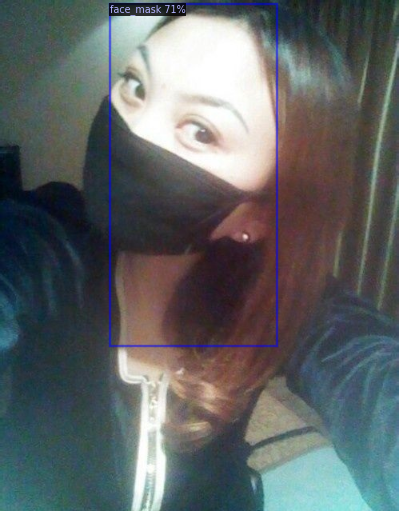

images/test_00000769.jpg


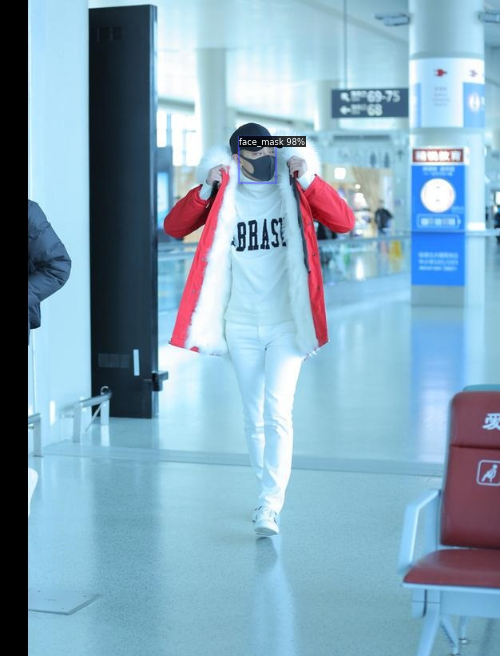

images/16_Award_Ceremony_Awards_Ceremony_16_59.jpg


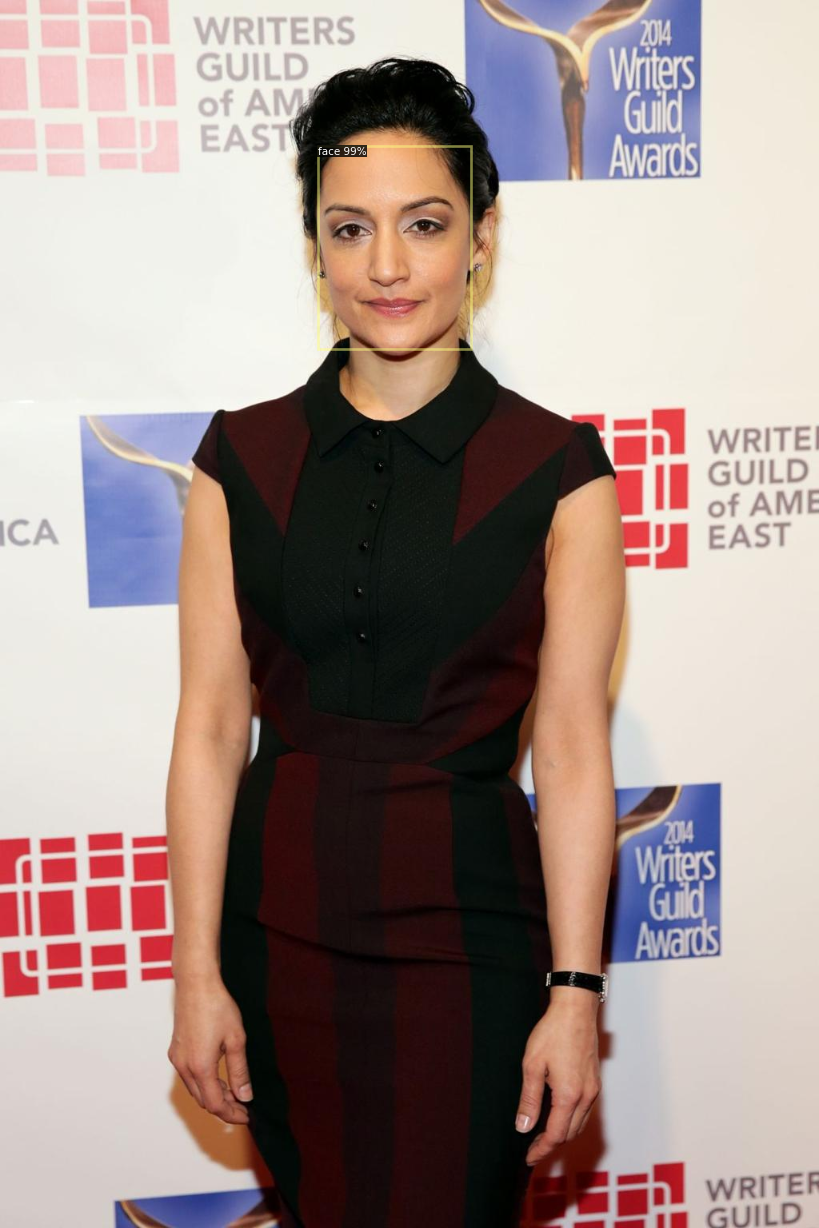

images/test_00001810.jpg


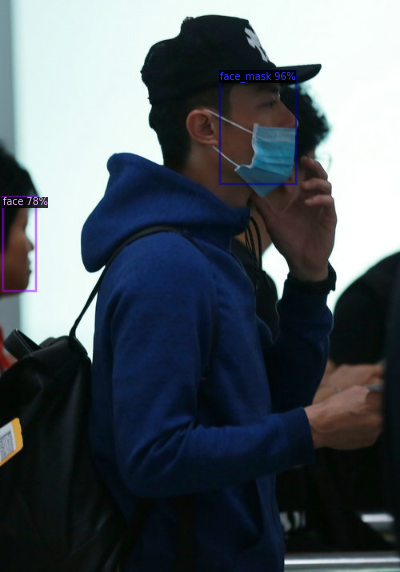

images/test_00001972.jpg


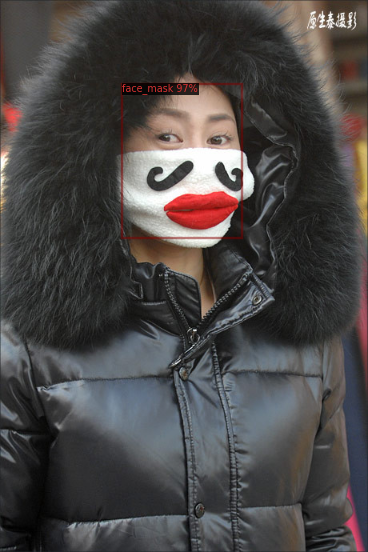

images/40_Gymnastics_Gymnastics_40_783.jpg


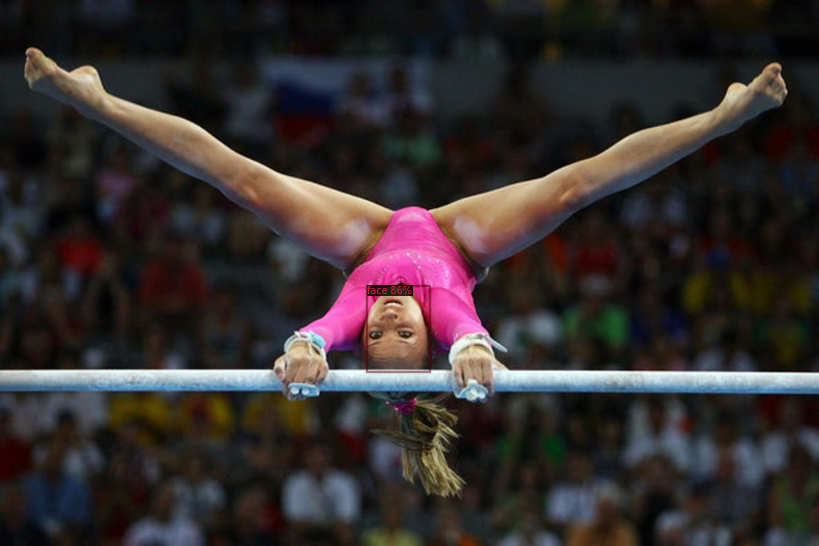

images/19_Couple_Couple_19_86.jpg


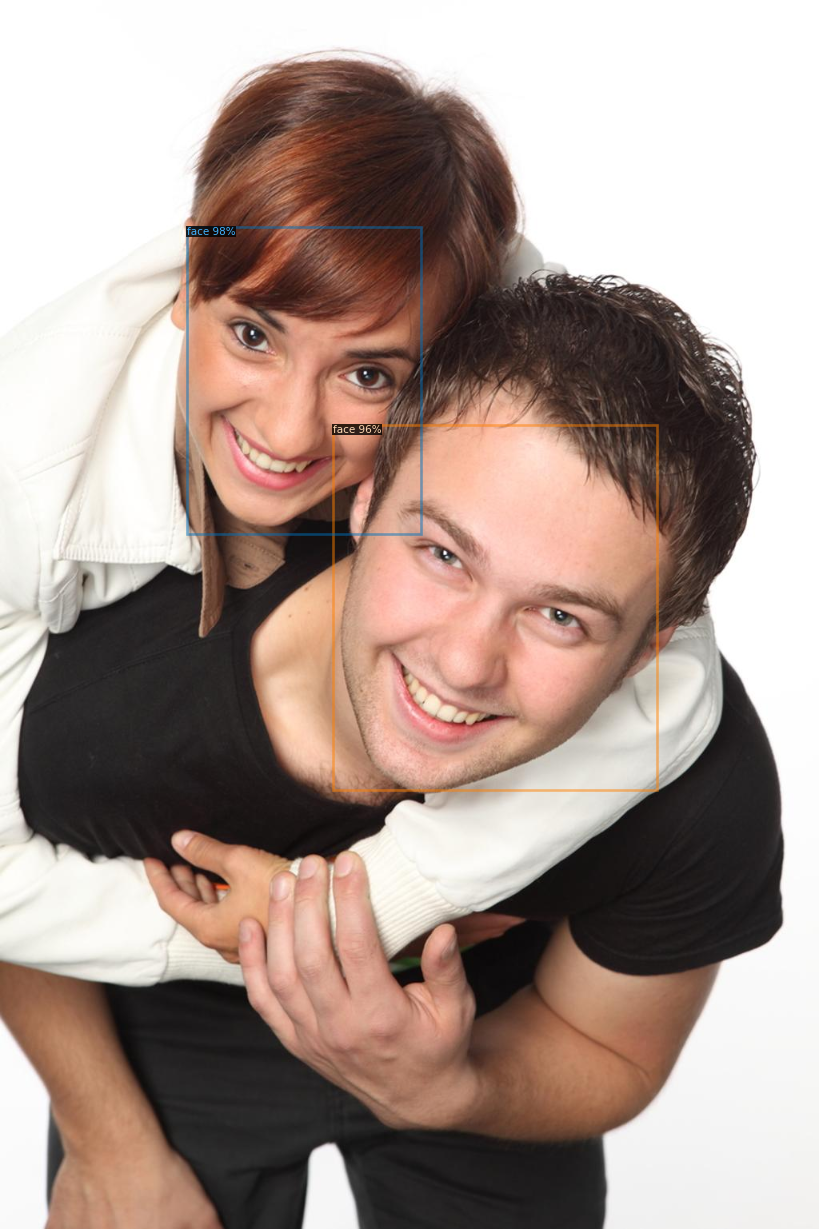

images/51_Dresses_wearingdress_51_789.jpg


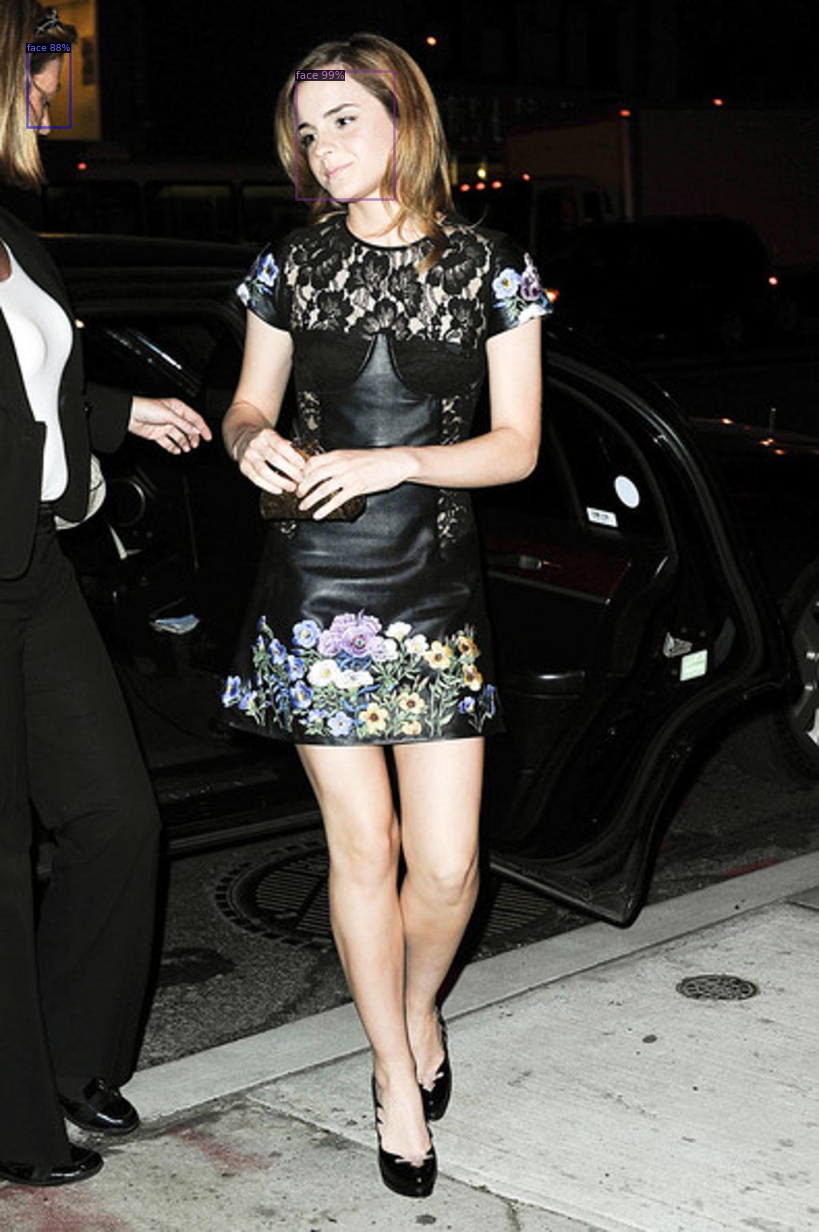

images/test_00003038.jpg


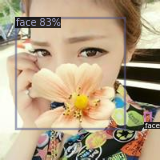

images/test_00004078.jpg


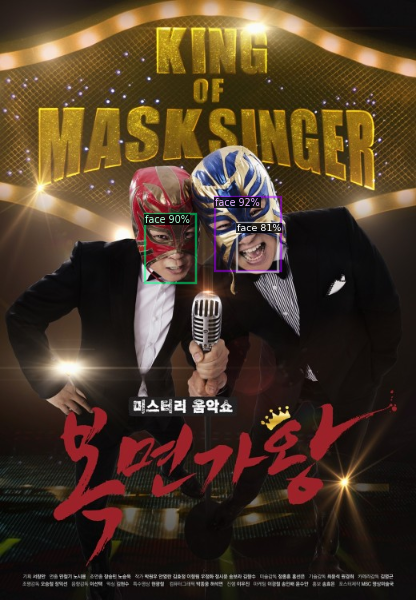

In [13]:
for d in test_dict:    
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_mask_metadata, 
                   scale=0.8, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])